In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.spatial.transform import Rotation as Rot
from numpy.linalg import inv
np.set_printoptions(precision=6, suppress=True)

In [54]:
idx_a, idx_b = 180, 150

trajs = np.load('000.npy')

videoCapture = cv2.VideoCapture('s-000.mp4')
images = []
while True:
    ret, frame = videoCapture.read()
    if not ret:
        break
    images.append(frame)

height, width, _ = images[0].shape

In [34]:
def project(pts, M):
    pts = pts.copy()
    o = np.ones([pts.shape[0], 1])
    pts = np.concatenate([pts, o], axis=1)
    pts = pts @ M.T
    return pts[:, :2] / pts[:, 2:3]

def draw_poly(pts, edge_color='b', marker=None, vert_color='b'):
    plt.gca().add_patch(patches.Polygon(
        pts, closed=True, edgecolor=edge_color, fill=False))
    if marker is not None:
        plt.scatter(pts[:, 0], pts[:, 1], marker=marker)

def find_H(img1, img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w,_ = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        M = None
        matchesMask = None

    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2)

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

    return M, img3


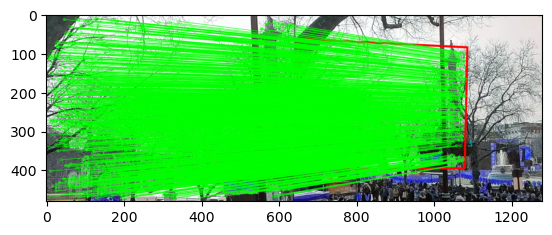

In [55]:
H_cv2, corr_img = find_H(images[idx_a], images[idx_b])
plt.imshow(corr_img, 'gray')
plt.show()

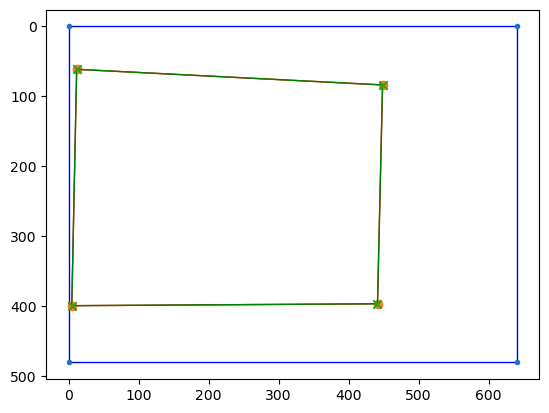

In [56]:
pts0 = np.array([
    [  0,   0],
    [640,   0],
    [640, 480],
    [  0, 480],
])

# Calculate focal length from horizontal FoV.
f0 = 0.5 * width / np.tan(np.radians(0.5 * trajs[idx_a, 3]))
f1 = 0.5 * width / np.tan(np.radians(0.5 * trajs[idx_b, 3]))

K0 = np.array([
    [-f0, 0, 0.5 * width],
    [0, f0, 0.5 * height],
    [0, 0, 1],
])

K1 = np.array([
    [-f1, 0, 0.5 * width],
    [0, f1, 0.5 * height],
    [0, 0, 1],
])

R0 = Rot.from_euler('YXZ', trajs[idx_a, :3], degrees=True).as_matrix()
R1 = Rot.from_euler('YXZ', trajs[idx_b, :3], degrees=True).as_matrix()

H_gt = (K1) @ inv(R1) @ (R0) @ inv(K0)
H_gt /= H_gt[2,2]

pts1 = project(pts0, H_gt)
pts_H_cv2 = project(pts0, H_cv2)

draw_poly(pts0, marker='.')
draw_poly(pts1, marker='o', edge_color='r')
draw_poly(pts_H_cv2, marker='x', edge_color='g')

# Set origin to top-left (computer graphics screen coordinates convention)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

plt.show()

In [57]:
def reprojection_error(M, src_pts, expected_pts):
    src_pts = src_pts.copy()
    got_pts = project(src_pts, M)
    plt.scatter(got_pts[:,0], got_pts[:,1], marker='x', c='r')
    plt.scatter(expected_pts[:,0], expected_pts[:,1], marker='x', c='g')
    plt.show()
    return np.sqrt(np.square(got_pts - expected_pts).sum(axis=1)).mean()

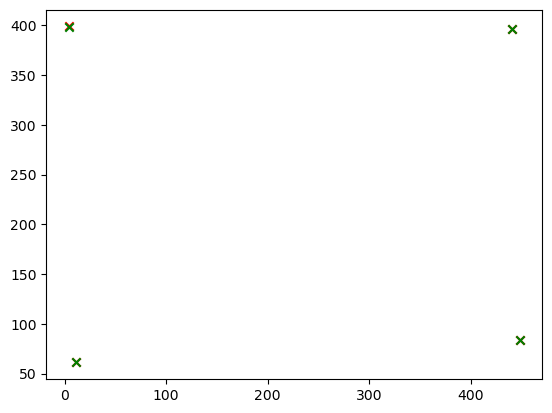

0.0926762256198186


In [58]:
print(reprojection_error(H_gt, pts0, pts_H_cv2))